# Simulation von Energiesystemen
### Beispielaufgabe: Wärmepumpen-/Gasheizungssystem

Sie sollen die Wärmeversorgung für ein Einfamilienhaus auslegen. Die Gasheizung ihres Auftraggebers muss ersetzt werden. Er überlegt anstelle einer neue Gasheizung eine Wärmepumpe einzubauen, da er bereits plant eine PV-Anlage mit 10 kWp, sowie einen Batterispeicher von 6 kWh zu installieren. Neben der Selbstversorgung wird kann die ENergie aus der PV-Anlage mit 8 ct je eingespeiste kWh vergütet werden.
Als weitere Informationen haben Sie einen simulierten Heizlastgang des Gebäudes, sowie den Stromverbrauch zur Verfügung gestellt bekommen. Ebenfalls besitzt er einen 100 l Warmwasserspeicher.


Importieren Sie die notwendigen Bibliotheken

In [ ]:
# Importieren der Bibliotheken
import numpy as np
import pandas as pd
import pypsa
import matplotlib.pyplot as plt

In [ ]:
def surface_plot(data,data_name,columns_name,index_name,azimut = []):
    """"  
    The function creates surface plots to visualize sensitivity analyses
    
    Input:
    
    data (list)        : list of dataframes with data from sensitivity analyses

    data_name (list)   : list of names for each plot in the form of strings

    columns_name (str) : name of the x-axis (input parameter of sensitivity analysis)

    index_name (str)   : name of the y-axis (input parameter of sensitivity analysis)

    azimut (list)      : list of  angles (int) to rotate the plot for better display

    Output: 
    Surface Plots
   
    """
    X, Y = np.meshgrid(data[0].columns,data[0].index)

    fig = plt.figure(figsize=(20,10))
    for i, df in enumerate(data):
        if not azimut == 0:
            azi = azimut[i]
        else:
            azi = 0    

        ax = fig.add_subplot(1, len(data), i+1, projection='3d')
        ax.plot_surface(X, Y, df, rstride=1, cstride=1,
                        cmap='viridis', edgecolor='none')
        ax.set_xlabel(index_name)
        ax.set_ylabel(columns_name)
        ax.set_title(data_name[i])
        ax.view_init(azim=azi)

    plt.show()

Lesen Sie die Daten ein

In [ ]:
# Einlesen der Daten
df_data = pd.read_excel("input_data.xlsx")
df_data.plot()

Im Folgenden wird anhand des Datenblatts der Wärmepumpe die Leistungszahl (COP) und die elektrische Leistungsaufnahme in Abhängikeit der Außentemperatur interpoliert. Die Daten für die Wärmepumpe basieren auf der Viessmann VITOCAL 252-A (Typ AWOT-E-AC-AF 251.A13) mit einer elektrischen Nennleistung nach DIN 14511 (A7/W35) von 1,56 kW. <br>
Quelle: https://www.viessmann.de/content/dam/public-brands/master/products/heat-pump/vitocal-252-a/DB-6195459-vitocal-252-a.pdf/_jcr_content/renditions/original.media_file.download_attachment.file/DB-6195459-vitocal-252-a.pdf

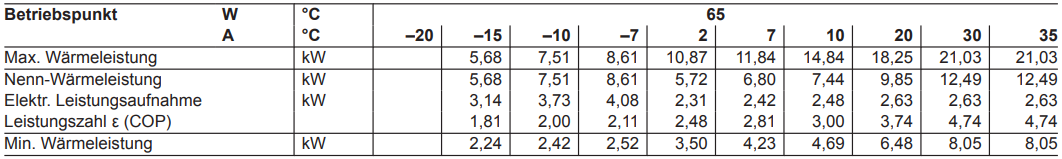

In [ ]:
temp        =   [ -15, -10,  -7,   2,   7,  10,  20,  30,  35] #°C
el_power    =   [3.14,3.73,4.08,2.31,2.42,2.48,2.63,2.63,2.63] #kW
cop         =   [1.81,2.00,2.11,2.38,2.81,3.00,3.74,4.74,4.74]
hp_p_nom    =   1.56 #kW

In [ ]:
df_data["COP_heat_pump"] = np.interp(df_data['temperature[°C]'],temp,cop)
df_data["el_p_pu"]       = (np.interp(df_data['temperature[°C]'],temp,el_power))/hp_p_nom

In [ ]:
df_data["el_p_pu"].plot()
df_data["COP_heat_pump"].plot()


In [ ]:
df_data.loc[:,["temperature[°C]","COP_heat_pump","el_p_pu"]].sort_values(['temperature[°C]']).plot(x='temperature[°C]')

### Netzwerkskizze

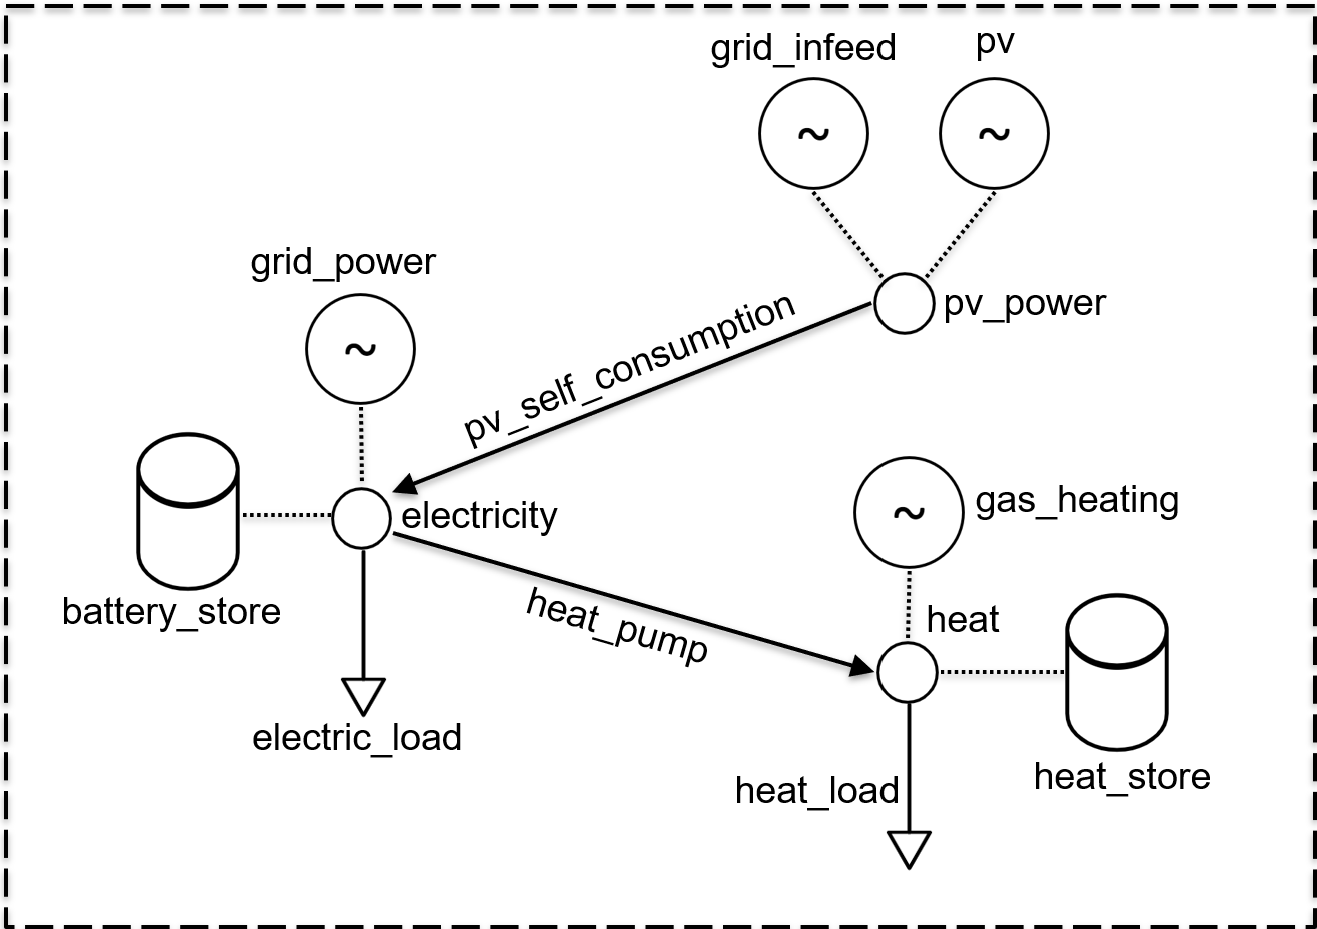

Implementieren Sie das Netzwerk. 
Nutzen Sie dabei die folgenden Angaben.

In [ ]:
# Eingangsparameter
"""Kapazitäten & Leistungen"""
pv_p_nom                    = 10    # kWp (Leistung der PV-Anlage)
gas_p_nom                   = 10    # kW  (Leistung der Gastherme)
battery_e_nom               = 6     # kWh (Batteriekapazität)
heat_store_e_nom            = 2.9   # kWh (Pufferspeicherkapazität mit 100 l bei einer Temperaturspreizung von 25 K)

"""Lebensdauern"""          # (Dienen hier der Berechnung der Kosten und haben keinen Einfaluss auf die Optimierung)
lifespan_pv                 = 20    # Jahre (Lebensdauer PV-Anlage)
lifespan_hp                 = 20    # Jahre (Lebensdauer Wärmepumpe)
lifespan_battery            = 15    # Jahre (Lebensdauer Batterie)
lifespan_heat_store         = 25    # Jahre (Lebensdauer Pufferspeicher)
lifespan_gas_heating        = 20    # Jahre (Lebensdauer Gasheizung)

"""Investmentkosten"""
invest_pv_annuity           = 65    # €/(kW*a)  (Annuität der PV-Anlage) 
invest_hp_annuity           = 480   # €/(kW*a)  (Annuität der Wärmepumpe)
invest_battery_annuity      = 25    # €/(kWh*a) (Annuität der Batterie)
invest_heat_store_annuity   = 5     # €/(kWh*a) (Annuität des Wärmespeichers)
invest_gas_heating_annuity  = 40    # €/(kW*a)  (Annuität der Gasheizung)

"""Marginalkosten"""
electrical_rate         = 0.34  # €/kWh (Strompreis)
feed_in_tariff          =-0.08  # €/kWh (Einspeisevergütung)
gas_rate                = 0.1035# €/kWh (Gaspreis)

"""Verluste"""
heat_storage_loss       = 0.005 # 1/h (Verlustrate des Pufferspeichers)

"""THG-Emissionen"""
co2_german_electricity  = 0.380 # kg_CO2/kWh
co2_gas                 = 0.200 # kg_CO2/kWh

In [ ]:
# Netzwerk aufbauen
network = pypsa.Network()
network.set_snapshots(range(8760))

#Carrier
network.add('Carrier',
            name            = 'german_electricity',
            co2_emissions   = co2_german_electricity) 
network.add('Carrier',
            name            = 'gas',
            co2_emissions   = co2_gas) 

#Bus
network.add('Bus', name     = 'pv_power')
network.add('Bus', name     = 'electricity')
network.add('Bus', name     = 'heat')

#Load
network.add('Load',
            name            = 'electric_load', 
            bus             = 'electricity', 
            p_set           = df_data["electrical_load[kW]"])
network.add('Load', 
            name            = 'heat_load', 
            bus             = 'heat', 
            p_set           = df_data["heat_load[kW]"])

#Generator
network.add('Generator',
            name            = 'grid_power',
            bus             = 'electricity', 
            p_nom           = np.inf, 
            marginal_cost   = electrical_rate,
            carrier         = 'german_electricity')
network.add('Generator',
            name            = 'PV', 
            bus             = 'pv_power', 
            p_nom           = pv_p_nom, 
            p_max_pu        = df_data["PV[W/Wp]"],
            capital_cost    = invest_pv_annuity,
            lifetime        = lifespan_pv) 
network.add('Generator',
            name            = 'grid_infeed', 
            bus             = 'pv_power', 
            p_nom           = np.inf, 
            marginal_cost   = feed_in_tariff,
            sign            = -1)
network.add('Generator',
            name            = 'gas_heating', 
            bus             = 'heat', 
            p_nom_max       = gas_p_nom,
            p_nom_extendable= True, 
            marginal_cost   = gas_rate,
            capital_cost    = invest_gas_heating_annuity,
            lifetime        = lifespan_gas_heating, 
            carrier         = 'gas')

#Link
network.add('Link',
            name            = 'heat_pump',
            bus0            = 'electricity', 
            bus1            = 'heat',
            efficiency      = df_data['COP_heat_pump'],
            p_nom_extendable= True,
            capital_cost    = invest_hp_annuity,
            p_max_pu        = df_data["el_p_pu"],
            lifetime        = lifespan_hp) 
network.add('Link',
            name            = 'pv_self_consumption',
            bus0            = 'pv_power', 
            bus1            = 'electricity',
            p_nom           = np.inf)

#Store
network.add('Store',
            name             = 'battery_store',
            bus              = 'electricity',
            e_nom            = battery_e_nom,
            e_nom_extendable = False,
            capital_cost     = invest_battery_annuity,
            lifetime         = lifespan_battery ) 
network.add('Store',
            name             = 'heat_store',
            bus              = 'heat',
            e_nom            = heat_store_e_nom,
            e_nom_extendable = False,
            capital_cost     = invest_heat_store_annuity,
            standing_loss    = heat_storage_loss,
            lifetime         = lifespan_heat_store) 

Optimieren Sie das Netzwerk

In [ ]:
network.optimize(solver_name = 'cbc', methods = 1, threads = 1)

Lassen Sie sich die Auslegung der Wärmepumpe, sowie der Gasheizung ausgeben

In [ ]:
print(" Wärmepumpenleistung:", round(network.links.p_nom_opt.heat_pump,2),"kW \n",
      "Gasheizung:", round(network.generators.p_nom_opt.gas_heating,2),"kW")

Lassen Sie sich die jährlichen Kosten des Systems berechnen und dessen Zusammensetzung grafisch ausgeben

In [ ]:
df_costs = pd.concat([network.generators.p_nom_opt * network.generators.capital_cost,
                             network.links.p_nom_opt * network.links.capital_cost,
                             network.stores.e_nom_opt * network.stores.capital_cost,
                             network.generators_t.p.sum() * network.generators.marginal_cost]).dropna()
df_costs = df_costs.groupby(df_costs.index).sum()
df_costs.iloc[0] -= df_costs.iloc[3]
df_costs = df_costs[df_costs > 0]

In [ ]:
df_costs

In [ ]:
print("Jährlichen Kosten des Systems:", round(df_costs.sum(),2), "€/a")
df_costs.plot.pie(autopct='%1.1f%%')

### Auslegeoptimierung der Speichersysteme

Lassen Sie nun auch die Speicherkapazitäten bei der Optimierung mit auslegen, um zu prüfen ob die aktuelle Auslegung angepasst werden sollte

In [ ]:
network.stores. loc["heat_store", "e_nom_extendable"] = True
network.stores. loc["battery_store", "e_nom_extendable"] = True

Optimieren Sie das Netzwerk

In [ ]:
network.optimize(solver_name = 'cbc', methods = 1, threads = 1)

Lassen Sie sich nun neben den Nennleistungen der Wärmepumpe und Gasheizung ebenfalls die Kapazitäten der Speicher ausgeben

In [ ]:
print(" Wärmepumpenleistung:", round(network.links.p_nom_opt.heat_pump,2),"kW \n",
      "Gasheizung:", round(network.generators.p_nom_opt.gas_heating,2),"kW \n",
      "Batteriespeicher:", round(network.stores.e_nom_opt.battery_store,2),"kWh \n",
      "Pufferspeicher:", round(network.stores.e_nom_opt.heat_store,2), "kWh")

Lassen Sie sich erneut die Kosten, sowie dessen Zusammensetzung ausgeben

In [ ]:
df_costs = pd.concat([network.generators.p_nom_opt * network.generators.capital_cost,
                             network.links.p_nom_opt * network.links.capital_cost,
                             network.stores.e_nom_opt * network.stores.capital_cost,
                             network.generators_t.p.sum() * network.generators.marginal_cost]).dropna()
df_costs = df_costs.groupby(df_costs.index).sum()
df_costs.iloc[0] -= df_costs.iloc[3]
df_costs = df_costs[df_costs > 0]


In [ ]:
print("Jährlichen Kosten des Systems:", round(df_costs.sum(),2), "€/a")
df_costs.plot.pie(autopct='%1.1f%%')

### CO2-Limitierung

Ihr Auftraggeber will nun zusätzlich auch seine CO2-Emissionen um 40% reduzieren. Berechnen Sie hierzu die CO2-Emissionen nach der aktuellen Auslegung

In [ ]:
co2 = (network.generators_t.p.grid_power.sum() * network.carriers.co2_emissions.german_electricity +
       network.generators_t.p.gas_heating.sum() * network.carriers.co2_emissions.gas)
print("CO2-Emissionen:",round(co2,2),"kg/a")

Fügen Sie nun eine Randbedingung hinzu um die Emissionen zu limitieren

In [ ]:
network.add('GlobalConstraint', name = 'co2-limit', 
           sense = '<=', carrier_attribute = 'co2_emissions',
           constant = 0.6 * co2)

In [ ]:
network.global_constraints

Optimieren Sie das System und lassen Sie sich die Auslegung sowie kosten ausgeben

In [ ]:
network.optimize(solver_name = 'cbc', methods = 1, threads = 1)

In [ ]:
print(" Wärmepumpenleistung:", round(network.links.p_nom_opt.heat_pump,2),"kW \n",
      "Gasheizung:", round(network.generators.p_nom_opt.gas_heating,2),"kW \n",
      "Batteriespeicher:", round(network.stores.e_nom_opt.battery_store,2),"kWh \n",
      "Pufferspeicher:", round(network.stores.e_nom_opt.heat_store,2), "kWh")

In [ ]:
df_costs = pd.concat([network.generators.p_nom_opt * network.generators.capital_cost,
                             network.links.p_nom_opt * network.links.capital_cost,
                             network.stores.e_nom_opt * network.stores.capital_cost,
                             network.generators_t.p.sum() * network.generators.marginal_cost]).dropna()
df_costs = df_costs.groupby(df_costs.index).sum()
df_costs.iloc[0] -= df_costs.iloc[3]
df_costs = df_costs[df_costs > 0]

In [ ]:
print("Jährlichen Kosten des Systems:", round(df_costs.sum(),2), "€/a")
df_costs.plot.pie(autopct='%1.1f%%')

### Sensitivitätsanalyse 

Führen Sie eine Sensitivitätsanalyse durch Variation des Gas- und Strompreis durch, die Berechnungszeit dauert allerdings sehr lange! 

In [ ]:
gas_range         = [6,8,10,12,14,16,18,20]
electricity_range = [40,36,32,28,24,20,16]

network.global_constraints.loc['co2-limit', 'constant'] = np.inf

df_results_hp = pd.DataFrame(index=gas_range, columns=electricity_range)
df_results_battery = df_results_hp.copy()
df_results_heat_store = df_results_hp.copy()
df_results_co2 = df_results_hp.copy()
for gas_price in gas_range:
    for electrical_price in electricity_range:
        network.generators.loc["grid_power", "marginal_cost"] = electrical_price/100
        network.generators.loc["gas_heating", "marginal_cost"] = gas_price/100
        network.optimize(solver_name = 'cbc', threads = 1)
        df_results_hp.loc[gas_price,electrical_price] = network.links.p_nom_opt.heat_pump
        df_results_battery.loc[gas_price,electrical_price] = network.stores.e_nom_opt.battery_store
        df_results_heat_store.loc[gas_price,electrical_price] = network.stores.e_nom_opt.heat_store
        df_results_co2.loc[gas_price,electrical_price] = (network.generators_t.p.grid_power.sum() * network.carriers.co2_emissions.german_electricity +
                                                          network.generators_t.p.gas_heating.sum() *  network.carriers.co2_emissions.gas)


Nutzen Sie die die Funktion "surface_plot" um sich die Sensitivitätsanalyse grafisch darstellen zu lassen

In [ ]:
data = [df_results_hp,df_results_battery,df_results_heat_store,df_results_co2]
data_name = ["Wärmepumpengröße [kW]","Pufferspeichergröße [kWh]","Batteriespeichergröße [kWh]","CO2-Emissionen [kg/a]"]
surface_plot(data,data_name,columns_name = 'Gaspreis [ct/kWh]',index_name = 'Strompreis [ct/kWh]',azimut = [0,210,330,120])